### Modelo de Machine Learning

In [ ]:
#librerias necesarias
import pandas as pd
import re
import emoji
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import joblib
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Cargar dataset
df = pd.read_csv(r"sentiment_analysis_dataset.csv")
print(df.shape)
df.head()

(2590, 5)


,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


In [3]:
print(f"Sentimientos dentro del dataframe: {df.sentiment.unique()}")

Sentimientos dentro del dataframe: ['scared' 'mad' 'sad' 'peaceful' 'powerful' 'joyful']


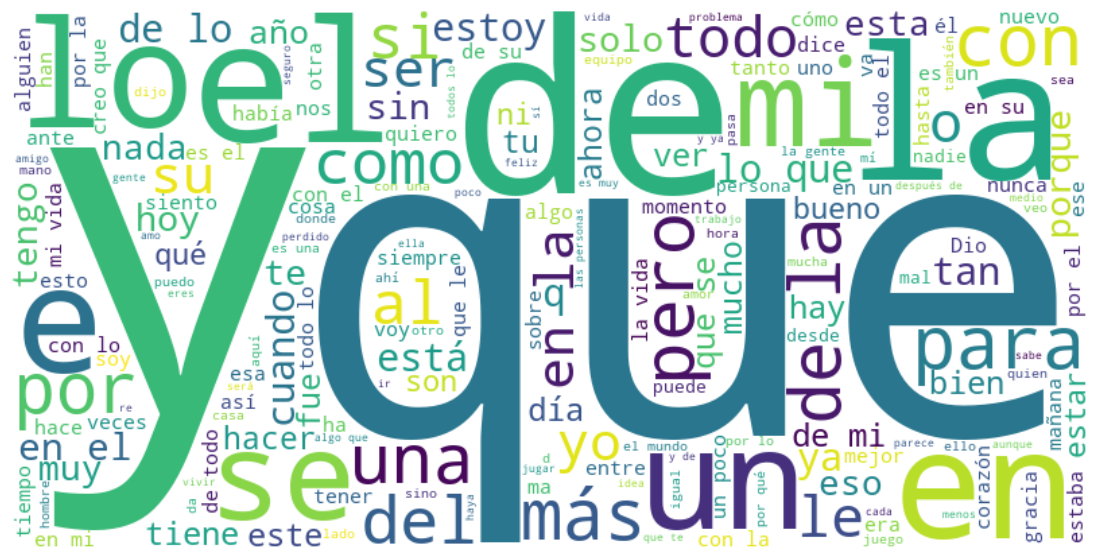

In [ ]:
#Analisis inicial de textos 
text = " ".join(df["text"].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=200,
                      colormap='viridis').generate(text)

wordcloud_array = np.array(wordcloud.to_image())
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_array, interpolation='bilinear')
plt.axis("off")
plt.show()

In [5]:
#Limpieza de texto dado que en el grafico anterior se identifican demaciados conectores y palabras que aportan poco valor al entrenamiento 
# de los modelos ademas de normalizacion de palabras del español
nlp = spacy.load("es_core_news_sm")

def limpiar_texto(texto):
    texto = texto.lower()
    texto = emoji.demojize(texto)             # 🙂 -> :Retira emoticones:
    texto = re.sub(r"http\S+", "", texto)     #Retira links
    texto = re.sub(r"@\w+", "<USER>", texto)  #Retira @
    texto = re.sub(r"#(\w+)", r"<HASHTAG> \1", texto)  #Retira #
    texto = re.sub(r"[^a-záéíóúñü\s:]", "", texto)     #Retira carateres propios del español

    doc = nlp(texto)
    palabras = [
        token.lemma_ for token in doc 
        if not token.is_stop or token.text in ["no","nunca","jamás"]
    ]
    return " ".join(palabras)

df["text_clean"] = df["text"].apply(limpiar_texto)
df["text"][:5], df["text_clean"][:5]

(0                 termine bien abrumado después de hoy
 1                                   me siento abrumado
 2    Me siento un poco abrumado por la cantidad de ...
 3    Salvador la única persona que no la ha abrumad...
 4       Denme un helado o algo que ando full abrumado.
 Name: text, dtype: object,
 0                                    terminar abrumado
 1                                      sentir abrumado
 2    sentir abrumado cantidad cosa querer dibujar j...
 3    salvador único persona no abrumar versión : re...
 4                       denmir helado ar full abrumado
 Name: text_clean, dtype: object)

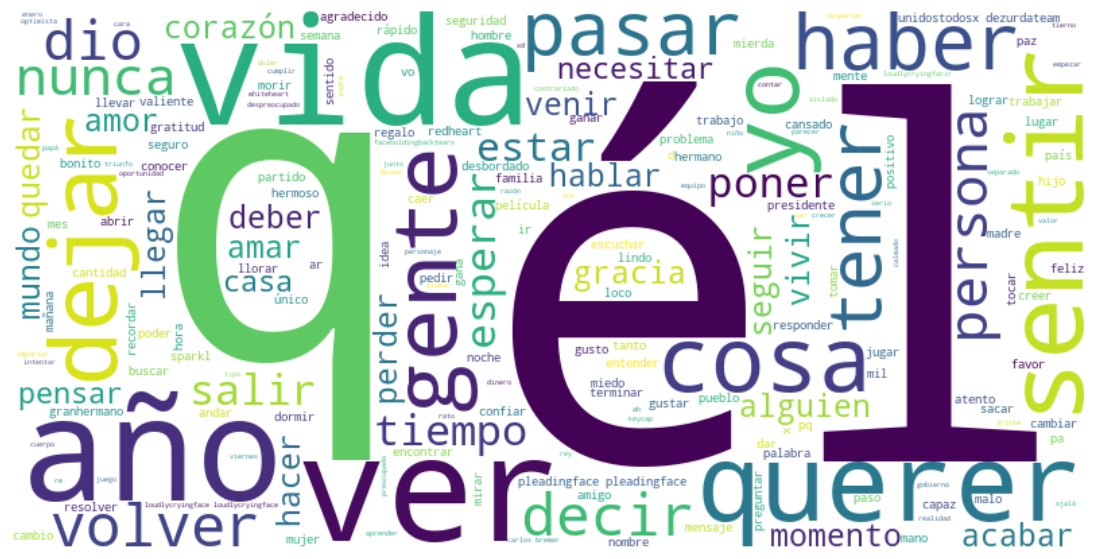

In [ ]:
text = " ".join(df["text_clean"].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      max_words=200,
                      colormap='viridis').generate(text)

wordcloud_array = np.array(wordcloud.to_image())
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_array, interpolation='bilinear')
plt.axis("off")
plt.show()

In [6]:
#Aplicamos traduciones de las categorias existentes a las categorias esperadas POSITIVO,NEGATIVO o NEUTRO.
translation = {
    'joyful': 'POSITIVO',
    'powerful': 'POSITIVO',
    'peaceful': 'NEUTRO',
    'sad': 'NEGATIVO',       
    'mad': 'NEGATIVO',    
    'scared': 'NEGATIVO',
}

df[['category']] = df[['sentiment']].replace(to_replace = translation)

Machine Learning Tradicional (TF-IDF + SVM)

In [7]:
X = df["text_clean"].astype(str)
y = df['category']

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words=list(nlp.Defaults.stop_words))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Entrenar modelo SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

# Evaluación
y_pred_svm = svm.predict(X_test_tfidf)
print("=== Resultados SVM (TF-IDF) ===")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))

=== Resultados SVM (TF-IDF) ===
              precision    recall  f1-score   support

    NEGATIVO       0.80      0.90      0.85       230
      NEUTRO       0.79      0.66      0.72       135
    POSITIVO       0.82      0.78      0.80       153

    accuracy                           0.80       518
   macro avg       0.80      0.78      0.79       518
weighted avg       0.80      0.80      0.80       518

[[208  12  10]
 [ 30  89  16]
 [ 22  12 119]]


c:\Users\Sebastian Rivera\Documents\Trabajos\Proteccion\pt_cientifico_proteccion\env\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [ ]:
# Guardar el modelo SVM
joblib.dump(svm, "svm.pkl")
# Guardar el vectorizador TF-IDF
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']